In [1]:
import time
import collections
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Log Likelihood Ratio for words following "he" or "she"

In [2]:
# Load category-specific bigram counters

with open('data/bigrams/female_sports.pkl', 'rb') as infile:
    female_sports = pickle.load(infile)
# with open('data/bigrams/female_monarch.pkl', 'rb') as infile:
#     female_monarch = pickle.load(infile)
with open('data/bigrams/female_scientist.pkl', 'rb') as infile:
    female_scientist = pickle.load(infile)
with open('data/bigrams/female_artists.pkl', 'rb') as infile:
    female_artists = pickle.load(infile)
with open('data/bigrams/female_programming.pkl', 'rb') as infile:
    female_programming = pickle.load(infile)
with open('data/bigrams/male_programming.pkl', 'rb') as infile:
    male_programming = pickle.load(infile)
with open('data/bigrams/male_scientist.pkl', 'rb') as infile:
    male_scientist = pickle.load(infile)
with open('data/bigrams/male_sports.pkl', 'rb') as infile:
    male_sports = pickle.load(infile)
with open('data/bigrams/male_artists.pkl', 'rb') as infile:
    male_artists = pickle.load(infile)
# with open('data/bigrams/male_monarch.pkl', 'rb') as infile:
#     male_monarch = pickle.load(infile)

In [3]:
# Load category-specific unigram counters
with open('data/bigrams/female_sports_u.pkl', 'rb') as infile:
    female_sports_u = pickle.load(infile)
# with open('data/bigrams/female_monarch_u.pkl', 'rb') as infile:
#     female_monarch_u = pickle.load(infile)
with open('data/bigrams/female_scientist_u.pkl', 'rb') as infile:
    female_scientist_u = pickle.load(infile)
with open('data/bigrams/female_artists_u.pkl', 'rb') as infile:
    female_artists_u = pickle.load(infile)
with open('data/bigrams/female_programming_u.pkl', 'rb') as infile:
    female_programming_u = pickle.load(infile)
with open('data/bigrams/male_programming_u.pkl', 'rb') as infile:
    male_programming_u = pickle.load(infile)
with open('data/bigrams/male_scientist_u.pkl', 'rb') as infile:
    male_scientist_u = pickle.load(infile)
with open('data/bigrams/male_sports_u.pkl', 'rb') as infile:
    male_sports_u = pickle.load(infile)
with open('data/bigrams/male_artists_u.pkl', 'rb') as infile:
    male_artists_u = pickle.load(infile)
# with open('data/bigrams/male_monarch_u.pkl', 'rb') as infile:
#     male_monarch_u = pickle.load(infile)

In [4]:
# count of x, count of y, count of xy
def pmi(cx, cy, cxy, n):
    if cy == 0:
        return 0
    if cxy == 0:
        return -100
    else:
        return np.log2(n) + np.log2(cxy) - (np.log2(cx) + np.log2(cy))

## Category: Scientist

In [5]:
# Number of words in corpus of women's SCIENTIST bios: 
n_women = sum(female_scientist_u.values())
n_women  # 2840901

2840901

In [6]:
# Number of words in corpus of men's SCIENTIST bios: 
n_men = sum(male_scientist_u.values())
n_men  # 12296493

12296493

In [28]:
# bigrams beginning with he or she, filtered by words appearing at least 75 times.

she = collections.Counter({ k[1]: v for k, v in female_scientist.items() if v >= 75 and k[0] == "she" })
he = collections.Counter({ k[1]: v for k, v in male_scientist.items() if v >= 75 and k[0] == "he" })

In [29]:
len(she)

49

In [30]:
sum(she.values())

19504

In [31]:
len(he)

149

In [32]:
sum(he.values())

90133

In [33]:
he_count = male_scientist_u['he']
she_count = female_scientist_u['she']
print("Number of times 'he' appears in male bios:", he_count )
print("Number of times 'she' appears in female bios:", she_count)

Number of times 'he' appears in male bios: 106235
Number of times 'she' appears in female bios: 26029


In [34]:
# Look up counts for all words in "he" counter not in "she" counter and vice versa
for word in he:
    if word not in she:
        she[word] = female_scientist[("she", word)]
for word in she:
    if word not in he:
        he[word] = male_scientist[("he", word)]

In [35]:
columns = ['Word following he/she', "she+word count"]
df = pd.DataFrame([(k,v) for k,v in she.items()], columns=columns)
df.set_index(['Word following he/she'], inplace=True)

In [36]:
columns2 = ['Word following he/she', "he+word count",]
df2 = pd.DataFrame([(k,v) for k,v in he.items()], columns=columns2)
df2.set_index(['Word following he/she'], inplace=True)

In [37]:
df = pd.concat([df,df2], axis=1)
df['total count'] = df.fillna(0)["she+word count"] + df.fillna(0)["he+word count"]
df.sort_values(by=['total count'], ascending=False, inplace=True)

In [38]:
df['PMI she+word'] = df.apply(lambda row: pmi(she_count, female_scientist_u[row.name], 
                                              row["she+word count"], n_women), axis=1)
df['PMI he+word'] = df.apply(lambda row: pmi(he_count, male_scientist_u[row.name], 
                                             row["he+word count"], n_men), axis=1)
df.head(10)

,she+word count,he+word count,total count,PMI she+word,PMI he+word
was,5683,22157,27840,5.027899,4.945018
is,1663,7190,8853,4.442270,4.281971
has,1188,4871,6059,5.091482,5.075041
also,830,3692,4522,4.579070,4.479146
had,704,2970,3674,4.546522,4.517743
became,754,2906,3660,5.402951,5.338857
received,770,2833,3603,5.549835,5.567863
worked,511,1896,2407,5.428528,5.458474
served,294,1497,1791,5.157580,5.317230
studied,311,1193,1504,5.581214,5.529775


In [39]:
# Log probabilities of word given he/she. Add 1 for smoothing
df['log prob of word | he'] = np.log2(
    (df.fillna(0)["he+word count"] + 1)) - np.log2((sum(he.values()) + 1))
df['log prob of word | she'] = np.log2(
    (df.fillna(0)["she+word count"] + 1)) - np.log2((sum(she.values()) + 1))

In [40]:
# Log likelihood ratio she : he
df['LLR'] = df['log prob of word | she'] - df['log prob of word | he']
df.sort_values(by=['LLR'], ascending=False, inplace=True)
df.head(30)

,she+word count,he+word count,total count,PMI she+word,PMI he+word,log prob of word | he,log prob of word | she,LLR
married,250,568,818,4.784584,4.836546,-7.307499,-6.481727,0.825772
traveled,43,103,146,5.441462,5.153327,-9.759344,-8.993839,0.765505
wanted,58,146,204,4.628066,4.892384,-9.260111,-8.570628,0.689484
told,31,80,111,4.116951,4.027025,-10.119934,-9.453271,0.666663
met,154,397,551,5.619019,5.266252,-7.823159,-7.177146,0.646013
currently,60,156,216,4.197195,3.509979,-9.165163,-8.522533,0.642630
undertook,30,79,109,5.676975,5.522000,-10.137856,-9.499074,0.638781
grew,45,118,163,4.596602,4.375543,-9.564966,-8.929709,0.635257
conducted,62,162,224,4.891391,4.482167,-9.111056,-8.475991,0.635065
earned,233,605,838,5.639918,5.595789,-7.216610,-6.582906,0.633704


In [41]:
df.tail(25)

,she+word count,he+word count,total count,PMI she+word,PMI he+word,log prob of word | he,log prob of word | she,LLR
argued,40,243,283,4.912104,4.716261,-8.529046,-9.095719,-0.566672
does,13,85,98,3.027581,3.240481,-10.033519,-10.645916,-0.612397
believed,45,286,331,4.931021,4.973056,-8.294877,-8.929709,-0.634832
soon,15,100,115,3.225764,3.408588,-9.801572,-10.453271,-0.651698
succeeded,15,100,115,4.746238,4.880315,-9.801572,-10.453271,-0.651698
claimed,19,126,145,4.210657,4.380913,-9.471099,-10.131343,-0.660243
tried,14,95,109,4.511351,4.539003,-9.874821,-10.546380,-0.671559
thought,18,125,143,2.841978,2.874453,-9.482504,-10.205343,-0.722839
finished,16,113,129,5.155375,5.244570,-9.626894,-10.365808,-0.738914
performed,13,93,106,3.784024,4.319861,-9.905195,-10.645916,-0.740721


In [42]:
he_words = df.drop(df[df['PMI he+word'] <= 0 ].index).tail(100)

In [43]:
she_words = df.drop(df[df['PMI she+word'] <= 0 ].index).head(100)

In [44]:
he_words.tail(20)

,she+word count,he+word count,total count,PMI she+word,PMI he+word,log prob of word | he,log prob of word | she,LLR
claimed,19,126,145,4.210657,4.380913,-9.471099,-10.131343,-0.660243
tried,14,95,109,4.511351,4.539003,-9.874821,-10.546380,-0.671559
thought,18,125,143,2.841978,2.874453,-9.482504,-10.205343,-0.722839
finished,16,113,129,5.155375,5.244570,-9.626894,-10.365808,-0.738914
performed,13,93,106,3.784024,4.319861,-9.905195,-10.645916,-0.740721
shared,15,108,123,3.547692,4.241225,-9.691599,-10.453271,-0.761671
led,44,314,358,3.027393,3.653110,-8.160576,-8.961418,-0.800842
subsequently,18,140,158,3.556306,4.048962,-9.320232,-10.205343,-0.885111
initiated,10,84,94,4.209370,4.592525,-10.050393,-10.993839,-0.943446
suggested,10,85,95,2.973072,3.730905,-10.033519,-10.993839,-0.960320


In [45]:
she_words.head(30)

,she+word count,he+word count,total count,PMI she+word,PMI he+word,log prob of word | he,log prob of word | she,LLR
married,250,568,818,4.784584,4.836546,-7.307499,-6.481727,0.825772
traveled,43,103,146,5.441462,5.153327,-9.759344,-8.993839,0.765505
wanted,58,146,204,4.628066,4.892384,-9.260111,-8.570628,0.689484
told,31,80,111,4.116951,4.027025,-10.119934,-9.453271,0.666663
met,154,397,551,5.619019,5.266252,-7.823159,-7.177146,0.646013
currently,60,156,216,4.197195,3.509979,-9.165163,-8.522533,0.642630
undertook,30,79,109,5.676975,5.522000,-10.137856,-9.499074,0.638781
grew,45,118,163,4.596602,4.375543,-9.564966,-8.929709,0.635257
conducted,62,162,224,4.891391,4.482167,-9.111056,-8.475991,0.635065
earned,233,605,838,5.639918,5.595789,-7.216610,-6.582906,0.633704


In [50]:
she_top = she_words.drop(she_words[she_words['she+word count'] < 75 ].index).head(15)['LLR']
Y1, X1 = she_top.index, she_top 
she_top

married      0.825772
met          0.646013
earned       0.633704
completed    0.619267
began        0.515632
attended     0.513773
continued    0.408435
said         0.375747
retired      0.310381
took         0.247999
graduated    0.219472
won          0.187753
started      0.163950
spent        0.153445
did          0.149376
Name: LLR, dtype: float64

In [51]:
Y2, X2 = he_words.tail(15).index, he_words.tail(15)['LLR']
he_words.tail(15)['LLR']

shared         -0.761671
led            -0.800842
subsequently   -0.885111
initiated      -0.943446
suggested      -0.960320
headed         -0.969239
defended       -1.029111
considered     -1.049340
designed       -1.133038
called         -1.252221
built          -1.293047
introduced     -1.315415
proposed       -1.565029
coined         -2.080950
invented       -2.362721
Name: LLR, dtype: float64

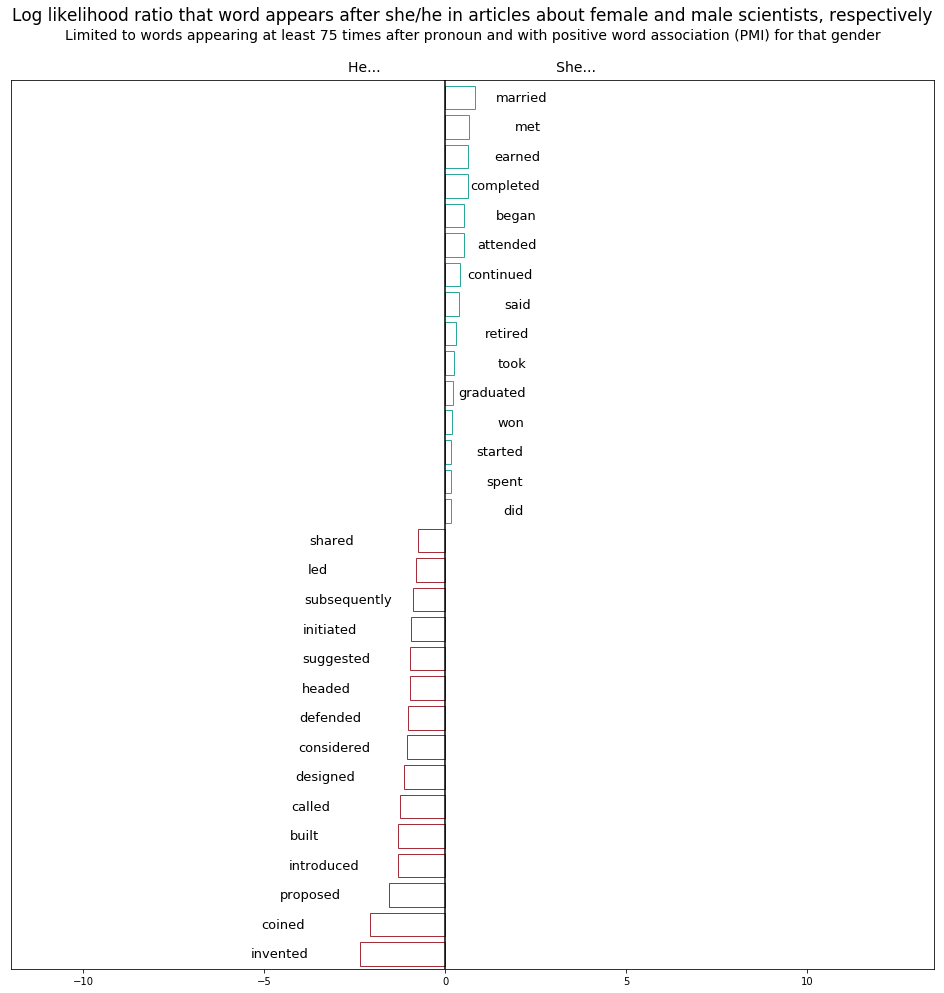

In [60]:
title="Log likelihood ratio that word appears after she/he in articles about female and male scientists, respectively"
subtitle="Limited to words appearing at least 75 times after pronoun and with positive word association (PMI) for that gender"
subtitle2="\n\nHe...                                       She..."

Y = np.arange(30)
X_women = np.concatenate((np.zeros(15), np.flip(X1.values, 0)), axis=0)
X_men = np.concatenate((np.flip(X2.values, 0), np.zeros(15)), axis=0)

plt.figure(figsize=(13.5,13))
plt.axes([0.025, 0.025, 0.95, 0.95])
plt.barh(Y, X_women, facecolor="None", edgecolor='#2ca79b')
plt.barh(Y, X_men, facecolor="None", edgecolor='#a52e3b')

for x, y, label in zip(X_women, Y, np.concatenate((np.empty(15, dtype="U") , np.flip(Y1,0)))):
    plt.text(x+2, y, label, ha='right', va= 'center', color="black", fontsize=13)
for x, y, label in zip(X_men, Y, np.concatenate((np.flip(Y2,0), np.empty(15, dtype="U")))):
    plt.text(x-3, y, label, ha='left', va= 'center', color="black", fontsize=13)


plt.title(title, fontsize=17, y=1.06)
plt.suptitle(subtitle + subtitle2, fontsize=14, y=1.03)
plt.axvline(x=0, color="black")
plt.ylim(-.5, 29.6)
plt.yticks(())
plt.xlim(-12, 13.5)
plt.show()

## Category: Artists

In [61]:
# Number of words in corpus of men and women's ARTISTS bios: 
n_women = sum(female_artists_u.values())
n_men = sum(male_artists_u.values())

# bigrams beginning with he or she, filtered by words appearing at least 75 times.
she = collections.Counter({ k[1]: v for k, v in female_artists.items() if v >= 75 and k[0] == "she" })
he = collections.Counter({ k[1]: v for k, v in male_artists.items() if v >= 75 and k[0] == "he" })

he_count = male_artists_u['he']
she_count = female_artists_u['she']

for word in he:
    if word not in she:
        she[word] = female_artists[("she", word)]
for word in she:
    if word not in he:
        he[word] = male_artists[("he", word)]

columns = ['Word following he/she', "she+word count"]
df = pd.DataFrame([(k,v) for k,v in she.items()], columns=columns)
df.set_index(['Word following he/she'], inplace=True)
columns2 = ['Word following he/she', "he+word count",]
df2 = pd.DataFrame([(k,v) for k,v in he.items()], columns=columns2)
df2.set_index(['Word following he/she'], inplace=True)

df = pd.concat([df,df2], axis=1)
df['total count'] = df.fillna(0)["she+word count"] + df.fillna(0)["he+word count"]
df.sort_values(by=['total count'], ascending=False, inplace=True)

df['PMI she+word'] = df.apply(lambda row: pmi(she_count, female_artists_u[row.name], 
                                              row["she+word count"], n_women), axis=1)
df['PMI he+word'] = df.apply(lambda row: pmi(he_count, male_artists_u[row.name], 
                                             row["he+word count"], n_men), axis=1)

# Log probabilities of word given he/she. Add 1 for smoothing
df['log prob of word | he'] = np.log2(
    (df.fillna(0)["he+word count"] + 1)) - np.log2((sum(he.values()) + 1))
df['log prob of word | she'] = np.log2(
    (df.fillna(0)["she+word count"] + 1)) - np.log2((sum(she.values()) + 1))

# Log likelihood ratio she : he
df['LLR'] = df['log prob of word | she'] - df['log prob of word | he']
df.sort_values(by=['LLR'], ascending=False, inplace=True)


he_words = df.drop(df[df['PMI he+word'] <= 0 ].index).tail(100)
she_words = df.drop(df[df['PMI she+word'] <= 0 ].index).head(100)

he_words.tail(30)

,she+word count,he+word count,total count,PMI she+word,PMI he+word,log prob of word | he,log prob of word | she,LLR
picked,24,95,119,3.561867,4.020610,-11.366186,-12.138425,-0.772240
read,31,122,153,1.858919,2.908634,-11.008634,-11.782282,-0.773648
led,68,270,338,2.411068,2.680915,-9.868999,-10.673757,-0.804758
d,114,455,569,0.857162,1.530431,-9.118258,-9.936792,-0.818533
ever,23,95,118,0.538650,1.469715,-11.366186,-12.197319,-0.831134
directed,64,260,324,2.293125,3.123923,-9.923242,-10.759914,-0.836672
produced,332,1345,1677,3.263215,3.901936,-7.556685,-8.402903,-0.846218
carried,20,85,105,3.671435,4.055091,-11.524883,-12.389964,-0.865081
quit,29,125,154,4.331120,4.423707,-10.973868,-11.875391,-0.901523
owned,23,102,125,2.765656,3.212599,-11.264648,-12.197319,-0.932672


In [62]:
she_words.head(30)

,she+word count,he+word count,total count,PMI she+word,PMI he+word,log prob of word | he,log prob of word | she,LLR
placed,836,155,991,5.852508,3.584022,-10.665746,-7.073198,3.592548
qualified,119,61,180,5.265387,4.799512,-11.996952,-9.875391,2.121561
sang,1025,830,1855,5.552048,5.252919,-8.252443,-6.779467,1.472977
auditioned,90,74,164,5.452698,5.192511,-11.722329,-10.274487,1.447842
sings,128,116,244,3.818992,3.368039,-11.080783,-9.771054,1.309729
starred,438,412,850,5.037241,4.752705,-9.261150,-8.004204,1.256946
competed,450,426,876,5.256862,4.774455,-9.213056,-7.965298,1.247758
photographed,81,85,166,4.371617,4.309556,-11.524883,-10.424730,1.100154
scored,181,191,372,5.565560,4.683200,-10.366186,-9.274487,1.091699
finished,391,416,807,5.481591,4.766644,-9.247245,-8.167572,1.079673


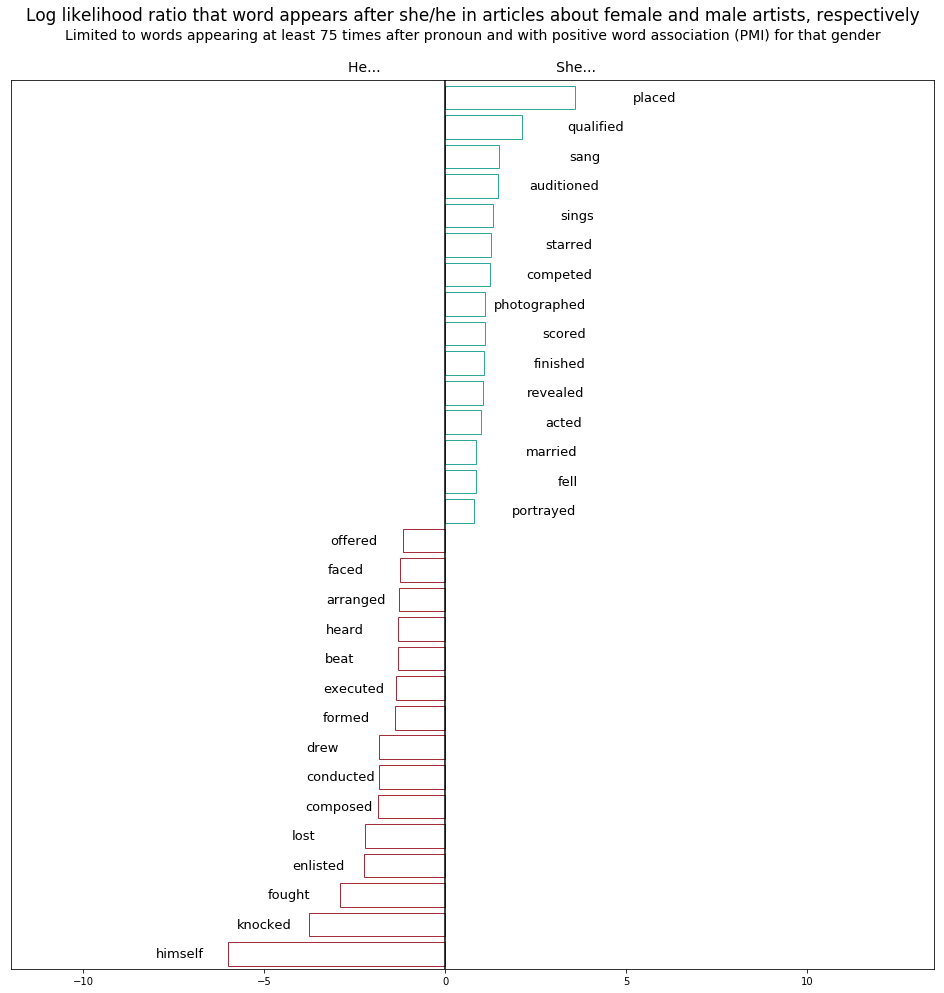

In [65]:
she_top = she_words.drop(she_words[she_words['she+word count'] < 75 ].index).head(15)['LLR']
Y1, X1 = she_top.index, she_top 
Y2, X2 = he_words.tail(15).index, he_words.tail(15)['LLR']

title="Log likelihood ratio that word appears after she/he in articles about female and male artists, respectively"
subtitle="Limited to words appearing at least 75 times after pronoun and with positive word association (PMI) for that gender"
subtitle2="\n\nHe...                                       She..."

Y = np.arange(30)
X_women = np.concatenate((np.zeros(15), np.flip(X1.values, 0)), axis=0)
X_men = np.concatenate((np.flip(X2.values, 0), np.zeros(15)), axis=0)

plt.figure(figsize=(13.5,13))
plt.axes([0.025, 0.025, 0.95, 0.95])
plt.barh(Y, X_women, facecolor="None", edgecolor='#2ca79b')
plt.barh(Y, X_men, facecolor="None", edgecolor='#a52e3b')

for x, y, label in zip(X_women, Y, np.concatenate((np.empty(15, dtype="U") , np.flip(Y1,0)))):
    plt.text(x+2.8, y, label, ha='right', va= 'center', color="black", fontsize=13)
for x, y, label in zip(X_men, Y, np.concatenate((np.flip(Y2,0), np.empty(15, dtype="U")))):
    plt.text(x-2, y, label, ha='left', va= 'center', color="black", fontsize=13)


plt.title(title, fontsize=17, y=1.06)
plt.suptitle(subtitle + subtitle2, fontsize=14, y=1.03)
plt.axvline(x=0, color="black")
plt.ylim(-.5, 29.6)
plt.yticks(())
plt.xlim(-12, 13.5)
plt.show()

## Category: Sports

In [66]:
# Number of words in corpus of men and women's SPORTS bios: 
n_women = sum(female_sports_u.values())
n_men = sum(male_sports_u.values())

# bigrams beginning with he or she, filtered by words appearing at least 75 times.
she = collections.Counter({ k[1]: v for k, v in female_sports.items() if v >= 75 and k[0] == "she" })
he = collections.Counter({ k[1]: v for k, v in male_sports.items() if v >= 75 and k[0] == "he" })

he_count = male_sports_u['he']
she_count = female_sports_u['she']

for word in he:
    if word not in she:
        she[word] = female_sports[("she", word)]
for word in she:
    if word not in he:
        he[word] = male_sports[("he", word)]

columns = ['Word following he/she', "she+word count"]
df = pd.DataFrame([(k,v) for k,v in she.items()], columns=columns)
df.set_index(['Word following he/she'], inplace=True)
columns2 = ['Word following he/she', "he+word count",]
df2 = pd.DataFrame([(k,v) for k,v in he.items()], columns=columns2)
df2.set_index(['Word following he/she'], inplace=True)

df = pd.concat([df,df2], axis=1)
df['total count'] = df.fillna(0)["she+word count"] + df.fillna(0)["he+word count"]
df.sort_values(by=['total count'], ascending=False, inplace=True)

df['PMI she+word'] = df.apply(lambda row: pmi(she_count, female_sports_u[row.name], 
                                              row["she+word count"], n_women), axis=1)
df['PMI he+word'] = df.apply(lambda row: pmi(he_count, male_sports_u[row.name], 
                                             row["he+word count"], n_men), axis=1)

# Log probabilities of word given he/she. Add 1 for smoothing
df['log prob of word | he'] = np.log2(
    (df.fillna(0)["he+word count"] + 1)) - np.log2((sum(he.values()) + 1))
df['log prob of word | she'] = np.log2(
    (df.fillna(0)["she+word count"] + 1)) - np.log2((sum(she.values()) + 1))

# Log likelihood ratio she : he
df['LLR'] = df['log prob of word | she'] - df['log prob of word | he']
df.sort_values(by=['LLR'], ascending=False, inplace=True)

he_words = df.drop(df[df['PMI he+word'] <= 0 ].index).tail(100)
she_words = df.drop(df[df['PMI she+word'] <= 0 ].index).head(100)
he_words.tail(30)

,she+word count,he+word count,total count,PMI she+word,PMI he+word,log prob of word | he,log prob of word | she,LLR
coached,29,350,379,2.750633,4.482452,-9.036847,-10.528389,-1.491542
resigned,10,128,138,5.076819,5.059008,-10.480947,-11.975848,-1.494901
rejoined,7,94,101,5.521604,5.525421,-10.922318,-12.435280,-1.512961
might,7,97,104,4.265265,4.920743,-10.877464,-12.435280,-1.557815
stayed,20,258,278,5.348121,5.654440,-9.475366,-11.042962,-1.567596
refused,7,98,105,3.462711,4.180518,-10.862817,-12.435280,-1.572462
remained,40,508,548,4.958175,5.343527,-8.500652,-10.077728,-1.577075
picked,10,139,149,4.097578,4.284864,-10.362891,-11.975848,-1.612957
featured,12,167,179,2.142707,3.874006,-10.099857,-11.734840,-1.634983
impressed,5,77,82,4.451215,4.394064,-11.206772,-12.850317,-1.643545


In [76]:
he_words.drop(['re'], axis=0, inplace=True)

In [67]:
she_words.head(30)

,she+word count,he+word count,total count,PMI she+word,PMI he+word,log prob of word | he,log prob of word | she,LLR
placed,699,769,1468,5.688565,5.021521,-7.903459,-5.984068,1.919391
reached,512,675,1187,5.645770,4.913777,-8.091295,-6.432465,1.658830
competes,59,82,141,4.094392,4.363010,-11.117135,-9.528389,1.588746
married,222,311,533,4.803609,4.104026,-9.206772,-7.634380,1.572392
improved,201,285,486,5.555086,4.957627,-9.332303,-7.777068,1.555235
jumped,67,97,164,5.873448,5.086133,-10.877464,-9.347817,1.529647
qualified,249,378,627,5.193125,4.798392,-8.926120,-7.469495,1.456625
ran,753,1226,1979,6.044076,5.506641,-7.231254,-5.876859,1.354396
ranked,57,98,155,2.984049,2.379947,-10.862817,-9.577299,1.285519
lives,64,110,174,4.689417,4.157757,-10.697758,-9.412912,1.284846


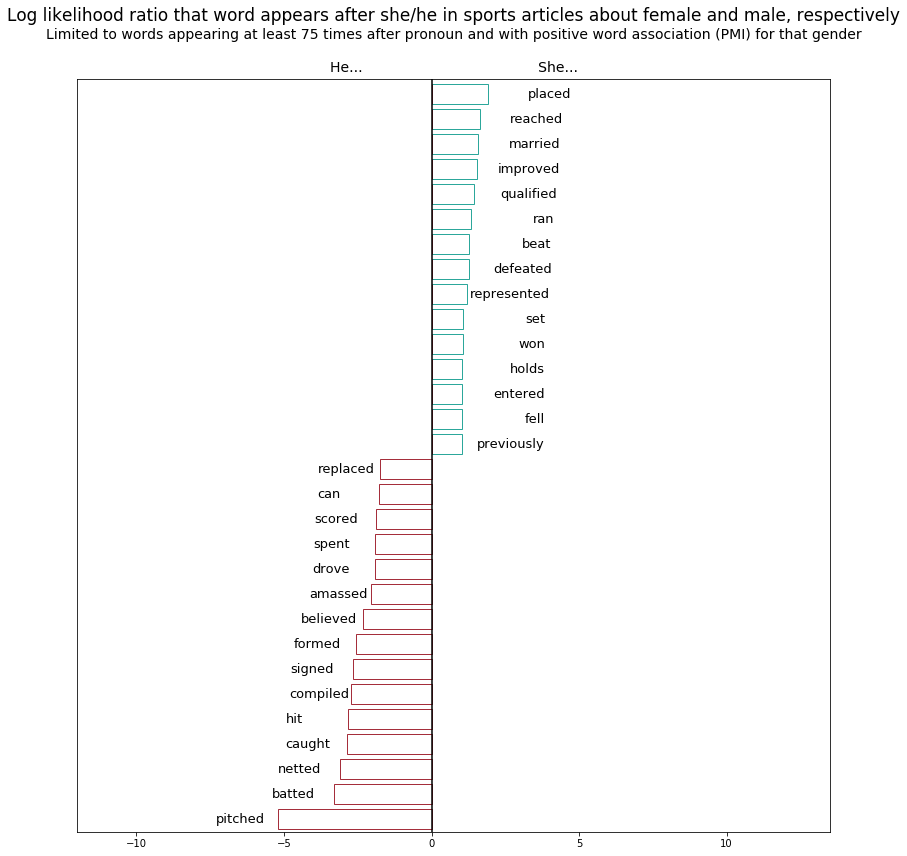

In [77]:
she_top = she_words.drop(she_words[she_words['she+word count'] < 75 ].index).head(15)['LLR']
Y1, X1 = she_top.index, she_top 
Y2, X2 = he_words.tail(15).index, he_words.tail(15)['LLR']

title="Log likelihood ratio that word appears after she/he in sports articles about female and male, respectively"
subtitle="Limited to words appearing at least 75 times after pronoun and with positive word association (PMI) for that gender"
subtitle2="\n\nHe...                                       She..."

Y = np.arange(30)
X_women = np.concatenate((np.zeros(15), np.flip(X1.values, 0)), axis=0)
X_men = np.concatenate((np.flip(X2.values, 0), np.zeros(15)), axis=0)

plt.figure(figsize=(11,11))
plt.axes([0.025, 0.025, 0.95, 0.95])
plt.barh(Y, X_women, facecolor="None", edgecolor='#2ca79b')
plt.barh(Y, X_men, facecolor="None", edgecolor='#a52e3b')

for x, y, label in zip(X_women, Y, np.concatenate((np.empty(15, dtype="U") , np.flip(Y1,0)))):
    plt.text(x+2.8, y, label, ha='right', va= 'center', color="black", fontsize=13)
for x, y, label in zip(X_men, Y, np.concatenate((np.flip(Y2,0), np.empty(15, dtype="U")))):
    plt.text(x-2.1, y, label, ha='left', va= 'center', color="black", fontsize=13)

plt.title(title, fontsize=17, y=1.07)
plt.suptitle(subtitle + subtitle2, fontsize=14, y=1.04)
plt.axvline(x=0, color="black")
plt.ylim(-.5, 29.6)
plt.yticks(())
plt.xlim(-12, 13.5)
plt.show()

## Category: Programming

In [88]:
# Number of words in corpus of men and women's PROGRAMMING bios: 
n_women = sum(female_programming_u.values())
n_men = sum(male_programming_u.values())

# bigrams beginning with he or she, filtered by words appearing at least 30 times.
she = collections.Counter({ k[1]: v for k, v in female_programming.items() if v >= 30 and k[0] == "she" })
he = collections.Counter({ k[1]: v for k, v in male_programming.items() if v >= 30 and k[0] == "he" })

he_count = male_programming_u['he']
she_count = female_programming_u['she']

for word in he:
    if word not in she:
        she[word] = female_programming[("she", word)]
for word in she:
    if word not in he:
        he[word] = male_programming[("he", word)]

columns = ['Word following he/she', "she+word count"]
df = pd.DataFrame([(k,v) for k,v in she.items()], columns=columns)
df.set_index(['Word following he/she'], inplace=True)
columns2 = ['Word following he/she', "he+word count",]
df2 = pd.DataFrame([(k,v) for k,v in he.items()], columns=columns2)
df2.set_index(['Word following he/she'], inplace=True)

df = pd.concat([df,df2], axis=1)
df['total count'] = df.fillna(0)["she+word count"] + df.fillna(0)["he+word count"]
df.sort_values(by=['total count'], ascending=False, inplace=True)

df['PMI she+word'] = df.apply(lambda row: pmi(she_count, female_programming_u[row.name], 
                                              row["she+word count"], n_women), axis=1)
df['PMI he+word'] = df.apply(lambda row: pmi(he_count, male_programming_u[row.name], 
                                             row["he+word count"], n_men), axis=1)

# Log probabilities of word given he/she. Add 1 for smoothing
df['log prob of word | he'] = np.log2(
    (df.fillna(0)["he+word count"] + 1)) - np.log2((sum(he.values()) + 1))
df['log prob of word | she'] = np.log2(
    (df.fillna(0)["she+word count"] + 1)) - np.log2((sum(she.values()) + 1))

# Log likelihood ratio she : he
df['LLR'] = df['log prob of word | she'] - df['log prob of word | he']
df.sort_values(by=['LLR'], ascending=False, inplace=True)

he_words = df.loc[(df['PMI he+word'] > 0) & (df['LLR'] < 0), ]
he_words

,she+word count,he+word count,total count,PMI she+word,PMI he+word,log prob of word | he,log prob of word | she,LLR
won,3,56,59,4.772765,4.553110,-7.028585,-7.047124,-0.018539
joined,8,129,137,4.825232,5.589872,-5.839107,-5.877199,-0.038092
started,7,117,124,5.047625,5.226618,-5.978832,-6.047124,-0.068292
continued,2,44,46,4.673229,5.030582,-7.369622,-7.462161,-0.092540
called,1,30,31,1.865874,2.824946,-7.907278,-8.047124,-0.139846
developed,5,93,98,4.857654,4.672099,-6.306886,-6.462161,-0.155276
has,37,598,635,5.262096,5.159993,-3.635062,-3.799196,-0.164134
helped,2,49,51,4.535726,5.050397,-7.217618,-7.462161,-0.244543
announced,1,33,34,2.825232,3.274311,-7.774012,-8.047124,-0.273112
served,4,85,89,4.602840,5.130055,-6.435210,-6.725196,-0.289986


In [89]:
she_words = df.loc[(df['PMI she+word'] > 0) & (df['LLR'] > 0), ]
she_words

,she+word count,he+word count,total count,PMI she+word,PMI he+word,log prob of word | he,log prob of word | she,LLR
did,13,71,84,5.269332,4.626854,-6.691550,-5.239769,1.451781
died,5,30,35,4.732123,4.993683,-7.907278,-6.462161,1.445117
led,6,38,44,4.722139,3.976907,-7.576072,-6.239769,1.336303
began,10,79,89,5.362889,4.819930,-6.539547,-5.587692,0.951854
holds,3,30,33,5.995157,5.225008,-7.907278,-7.047124,0.860154
took,7,63,70,5.632587,5.135263,-6.861475,-6.047124,0.814351
met,3,31,34,4.995157,5.051715,-7.861475,-7.047124,0.814351
could,4,41,45,3.568892,3.910135,-7.469157,-6.725196,0.743961
had,32,282,314,4.865874,4.738057,-4.716816,-4.002730,0.714087
wrote,14,137,151,5.444960,5.301638,-5.752950,-5.140233,0.612717


In [ ]:
# Pretty low word counts ... probably shouldn't use programming?